# Model engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
import pickle


df = pd.read_csv('../data/processed/yield.csv')
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,avg_temp
0,Albania,Maize,1990,36613,1485.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,16.37
2,Albania,Rice,1990,23333,1485.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,16.37


In [2]:
with open('../artifacts/encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)
encoded = pd.DataFrame(encoder.transform(
    df[['Item', 'Area']]), columns=encoder.get_feature_names_out())
df = df.drop(['Area', 'Item'], axis=1).join(encoded)
X = df.drop(['hg/ha_yield'], axis=1)
y = df['hg/ha_yield']

In [3]:
X.head()

,Year,average_rain_fall_mm_per_year,avg_temp,Item_Cassava,Item_Maize,Item_Plantains,Item_Potatoes,Item_Rice,Item_Sorghum,Item_Soybeans,...,Area_Tajikistan,Area_Thailand,Area_Tunisia,Area_Turkey,Area_Uganda,Area_Ukraine,Area_United Kingdom,Area_Uruguay,Area_Zambia,Area_Zimbabwe
0,1990,1485.0,16.37,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1990,1485.0,16.37,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1990,1485.0,16.37,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1990,1485.0,16.37,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1990,1485.0,16.37,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
y.head()

0    36613
1    66667
2    23333
3    12500
4     7000
Name: hg/ha_yield, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape

(20921, 114)

In [6]:
def accuracy_score(actual, estimate):
    mae = mean_absolute_error(actual, estimate)
    mape = mean_absolute_percentage_error(actual, estimate)
    rmse = root_mean_squared_error(actual, estimate)
    r2 = r2_score(actual, estimate)
    print(f' MAE: {mae:.3f}\n MAPE: {mape:.3f}\n' +
          f' RMSE: {rmse:.3f}\n R2: {r2:.3f}')

## Baseline model

### Purpose

In [7]:
regressor = LogisticRegression(max_iter=500)
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 6168.152
 MAPE: 0.151
 RMSE: 12301.403
 R2: 0.952


**Baseline model**: defined baseline accuracy for the predictor using `LogisticRegression` with default parameters.

---
## Model selection

In [8]:
forest = RandomForestRegressor(random_state=666, n_jobs=-1)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print('Score for RandomForestRegressor with default parameters')
accuracy_score(y_test, pred)

Score for RandomForestRegressor with default parameters
 MAE: 2888.345
 MAPE: 0.078
 RMSE: 7133.307
 R2: 0.984


In [9]:
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 30367.884
 MAPE: 0.764
 RMSE: 49357.338
 R2: 0.233


In [10]:
svm = SVR()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 41120.879
 MAPE: 1.265
 RMSE: 61998.647
 R2: -0.210


The model selected is **Random Forest** for its great applicability and higher efficiency in learning than SVM. Baseline `RandomForestRegressor` without any adjustment performs just better than `LogisticRegression` and is more efficient than `SVR` (in learning). Also `SVR` might have problems related to having many encoded categorical values.

---
## Hyperparameter Tuning

In [11]:
forest = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 25, 50],
    'min_samples_split': [4, 10],
    'min_samples_leaf': [2, 4],
    'criterion': ['squared_error', 'friedman_mse', 'poisson'],
    'max_features': [None, 1, 'sqrt', 'log2']
}
grid = GridSearchCV(forest, param_grid, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'criterion': 'poisson',
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 50}

Grid search gives us the best parameters for `RandomForestRegressor`:
- `n_estimators`: **50**
- `min_samples_split`: **4**
- `min_samples_leaf`: **2**
- `max_features`: **None**
- `criterion`: **poisson**

---
## Model evaulation

### Metrics

In [12]:
pred = grid.predict(X_test)
accuracy_score(y_test, pred)

 MAE: 3282.530
 MAPE: 0.088
 RMSE: 7918.544
 R2: 0.980


### Cross fold validation

In [13]:
estimators = [5, 10, 25, 50]
for estimator in estimators:
    forest.set_params(n_estimators=estimator, n_jobs=-1)
    score = cross_val_score(forest, X_train, y_train)
    print(f'CV-score for {estimator} estimators: {score.mean():.4f}')

CV-score for 5 estimators: 0.9756
CV-score for 10 estimators: 0.9780
CV-score for 25 estimators: 0.9794
CV-score for 50 estimators: 0.9797


The model chosen is a `RandomForestRegressor`.  
- **Metrics**: with the parameters obtained from the previous optimization, the regressor gains only a slight increase in accuracy for much longer train time.
- **Cross validation**: performed cross validation with different number of estimators to see if it could help reduce the prediction error. A lower value could be used to limit resources usage as there is no significant increase in the CV-score.

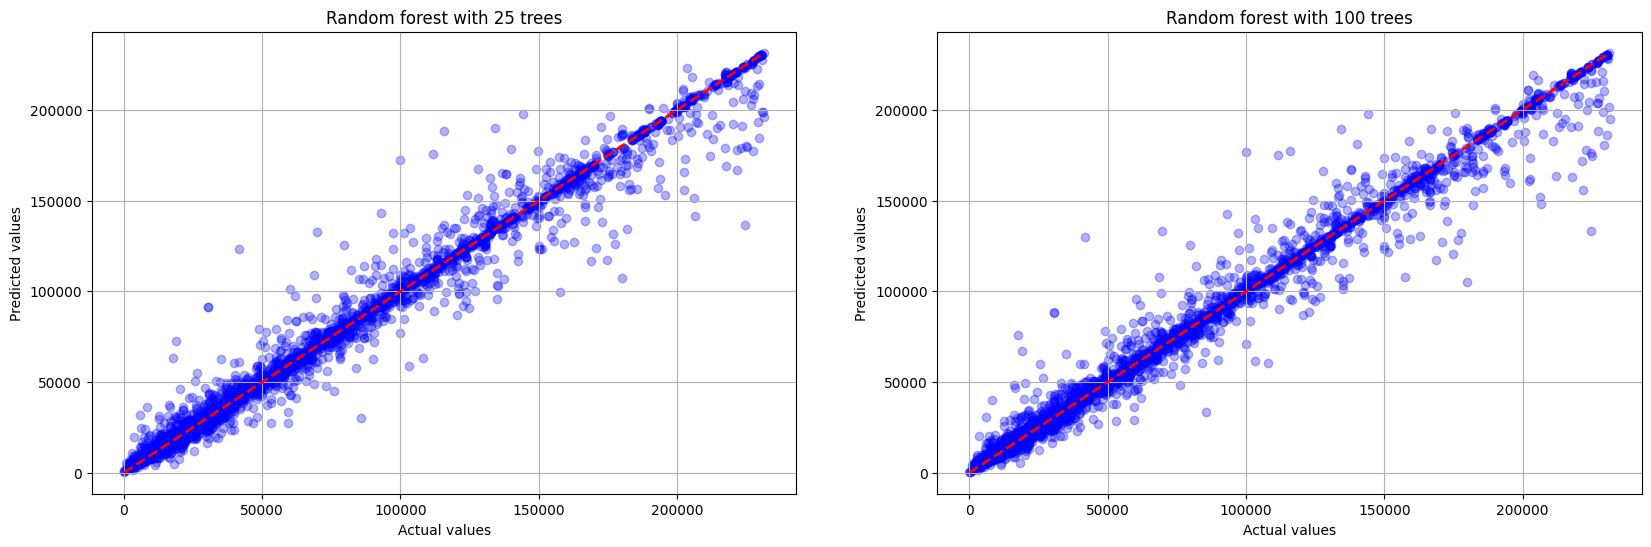

In [14]:
estimators = [25, 100]
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for idx, n_estimators in enumerate(estimators):
    forest.set_params(n_estimators=n_estimators)
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    ax = axs[idx]
    ax.scatter(y_test, pred, color='blue', alpha=0.3)
    ax.plot([min(y_test), max(y_test)], [min(y_test),
                                         max(y_test)], color='red', lw='2', ls='--')
    ax.set_title(f'Random forest with {n_estimators} trees')
    ax.set_xlabel("Actual values")
    ax.set_ylabel('Predicted values')
    ax.grid(True)
plt.show()

- plotted predictions against actual values: the model correctly predicts data as expected from the previous results.
---

## Feature importance and model interpretability

In [15]:
important = forest.feature_importances_.argsort()[::-1]
X.columns[important]

Index(['Item_Potatoes', 'Item_Sweet potatoes', 'Item_Cassava', 'Item_Yams',
       'average_rain_fall_mm_per_year', 'avg_temp', 'Year', 'Area_Mexico',
       'Area_Japan', 'Item_Plantains',
       ...
       'Area_Switzerland', 'Area_Armenia', 'Area_Tunisia', 'Area_Niger',
       'Area_Montenegro', 'Area_Netherlands', 'Area_Latvia', 'Area_Estonia',
       'Area_Germany', 'Area_Botswana'],
      dtype='object', length=114)

- **Feature importance**: from the model we can see above the most important features.
- Since the model has many rows due to the number of categories for the column `Area` (before encoding) Gini importance may not be accurate enough.

---

## Export the best model

In [16]:
with open('../artifacts/model.pkl', 'wb') as file:
    pickle.dump(grid.best_estimator_, file)
with open('../artifacts/encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)
with open('../artifacts/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

- **Model**: exported to `artifacts/model.pkl`
- **Encoder**: exported to `artifacts/encoder.pkl`
- **Scaler**: exported to `artifacts/scaler.pkl`

---

## Conclusions

- **Baseline model**: defined a baseline model using `LogisticRegression` with default parameters.
- **Model Selection**: inspected other models (`RandomForestRegressor` and `SVR`). Chosen `RandomForestRegressor`
- **Hyperparameter tuning**: best parameters for the regressor while also optimizing the model size.
- **Model evaluation**: measured accuracy of the model with **default metrics** and **cross validation**.
- **Feature importance**: displayed feature importance for model interpretability.
- **Export**: exported the model along with the scaler and encoder.